<a href="https://colab.research.google.com/github/mikolajsemeniuk/Unsupervised-binary-text-classification/blob/main/Unsupervised_binary_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised binary text classification

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from numpy import ndarray
from pandas.core.frame import DataFrame
from pandas.core.series import Series

from typing import List, Dict, Tuple, Callable, Any

## Load dataset

In [2]:
path: str = \
    '/content/drive/MyDrive/Data/datasets/spam_messages/SPAM text message 20170820 - Data.csv'

dataset: DataFrame = pd.read_csv(path)

dataset.shape

(5572, 2)

## Prepare dataset

### Clean text

In [3]:
from bs4 import BeautifulSoup
import re

def clean_text(text):
  text = BeautifulSoup(text, 'lxml').get_text()
  text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r"[^a-zA-Z.!?']", ' ', text)
  text = re.sub(r" +", ' ', text)
  return text

dataset['CleanMessage'] = pd.DataFrame(data=[clean_text(text) for text in dataset.Message])
dataset.CleanMessage = dataset.CleanMessage.astype('string')

dataset.head()

,Category,Message,CleanMessage
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy.. Available only i...
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in a wkly comp to win FA Cup final ...
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don't think he goes to usf he lives arou...


### Change columns types

In [4]:
dataset = dataset.convert_dtypes()

dataset.dtypes

Category        string
Message         string
CleanMessage    string
dtype: object

## Encode `Category` to numbers

In [5]:
from sklearn.preprocessing import LabelEncoder

y: ndarray = \
    LabelEncoder().fit_transform(dataset.Category)

y.shape, y[:10]

((5572,), array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1]))

## Encode `X` using `SubwordTextEncoder`

In [6]:
import tensorflow_datasets as tfds

raw_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    dataset.Message, target_vocab_size=2**16)

raw_sentences: List[int] = \
    [raw_tokenizer.encode(sentence) for sentence in dataset.Message]

clean_tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    dataset.CleanMessage, target_vocab_size=2**16)

clean_sentences: List[int] = \
    [clean_tokenizer.encode(sentence) for sentence in dataset.CleanMessage]

str(raw_sentences[0]), raw_tokenizer.decode(raw_sentences[0]), \
str(clean_sentences[0]), clean_tokenizer.decode(clean_sentences[0])

('[952, 509, 8730, 2173, 3, 3549, 73, 3961, 104, 10, 2779, 87, 187, 757, 4774, 188, 10210, 21, 12581, 120, 69, 10593, 377, 25]',
 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 '[911, 523, 7981, 1415, 4766, 53, 3699, 97, 9, 3340, 75, 174, 651, 3154, 175, 9422, 20, 11703, 102, 63, 9797, 359, 23]',
 'Go until jurong point crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

raw_max_len: int = \
    max([len(sentence) for sentence in raw_sentences])

X_raw: ndarray = \
    pad_sequences(raw_sentences, value = 0, 
                  padding = 'post',
                  maxlen = raw_max_len)
    
clean_max_len: int = \
    max([len(sentence) for sentence in clean_sentences])

X_clean: ndarray = \
    pad_sequences(clean_sentences, value = 0, 
                  padding = 'post',
                  maxlen = clean_max_len)

raw_max_len, clean_max_len, X_raw.shape, X_clean.shape

(210, 210, (5572, 210), (5572, 210))

## Calculate reconstruction error

In [8]:
from sklearn.metrics import average_precision_score

def predict(real: ndarray, constructed: ndarray) -> ndarray:
    loss: ndarray = np.sum((real - constructed) ** 2, axis = 1)
    min: ndarray = np.min(loss)
    return (loss - min) / (np.max(loss) - min)

## Define functions to plot results

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from numpy import float64

def plot_precision(y_true: ndarray, y_pred: ndarray) -> None:
    precision: ndarray
    recall: ndarray
    precision, recall, _ = \
    precision_recall_curve(y_true, y_pred)
    average_precision: float64 = \
    average_precision_score(y_true, y_pred)
    plt.figure(figsize=(16, 10))
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
    plt.show()

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_auc(y_true: ndarray, y_pred: ndarray) -> None:
    fpr: np.ndarray
    tpr: np.ndarray
    fpr, tpr, _ = \
    roc_curve(y_true, y_pred)
    areaUnderROC: float64 = auc(fpr, tpr)
    plt.figure(figsize=(16, 10))
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--', label='threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

## Apply `PCA`

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 15, whiten = False, random_state = 2018)

X_pca: ndarray = \
    pca.fit_transform(X_clean)

X_pca_inverse: ndarray = \
    pca.inverse_transform(X_pca)

y_pca_pred: ndarray = \
    predict(X_clean, X_pca_inverse)

f'precision: {average_precision_score(y, y_pca_pred)}'

'precision: 0.23184516239241176'

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 15, whiten = False, random_state = 2018)

X_pca: ndarray = \
    pca.fit_transform(X_raw)

X_pca_inverse: ndarray = \
    pca.inverse_transform(X_pca)

y_pca_pred: ndarray = \
    predict(X_raw, X_pca_inverse)

f'precision: {average_precision_score(y, y_pca_pred)}'

'precision: 0.40842627256716607'

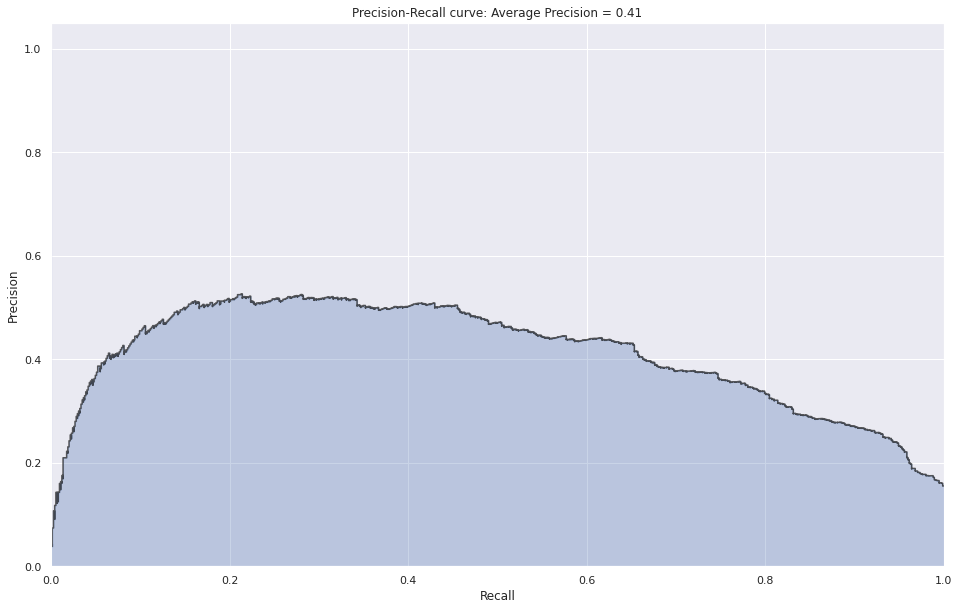

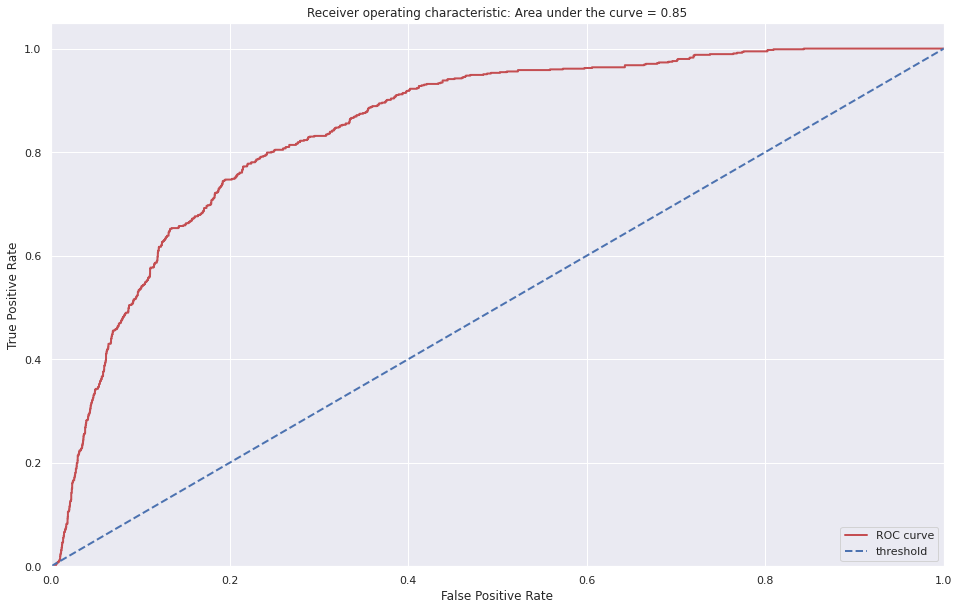

In [13]:
plot_precision(y, y_pca_pred)
plot_auc(y, y_pca_pred)

## Apply `IncrementalPCA`

In [14]:
from sklearn.decomposition import IncrementalPCA

incremental_pca = IncrementalPCA(n_components = 15, batch_size = None)

X_incremental_pca: ndarray = \
    incremental_pca.fit_transform(X_clean)

X_incremental_pca_inverse: ndarray = \
    incremental_pca.inverse_transform(X_incremental_pca)

y_pred_incremental_pca: ndarray = \
    predict(X_clean, X_incremental_pca_inverse)

f'precision: {average_precision_score(y, y_pred_incremental_pca)}'

'precision: 0.22832935221464623'

In [15]:
from sklearn.decomposition import IncrementalPCA

incremental_pca = IncrementalPCA(n_components = 15, batch_size = None)

X_incremental_pca: ndarray = \
    incremental_pca.fit_transform(X_raw)

X_incremental_pca_inverse: ndarray = \
    incremental_pca.inverse_transform(X_incremental_pca)

y_incremental_pca_pred: ndarray = \
    predict(X_raw, X_incremental_pca_inverse)

f'precision: {average_precision_score(y, y_incremental_pca_pred)}'

'precision: 0.40514868899018636'

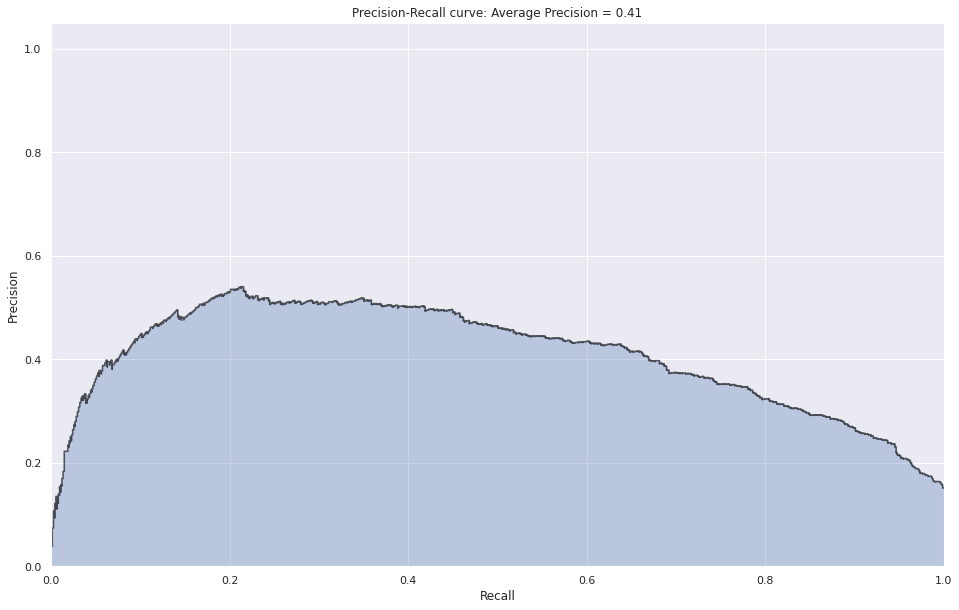

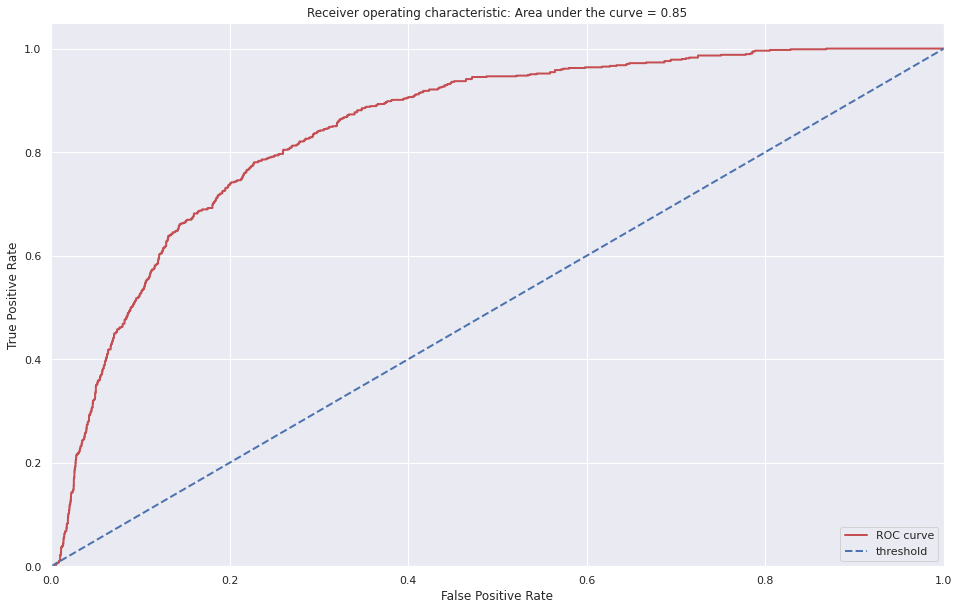

In [16]:
plot_precision(y, y_incremental_pca_pred)
plot_auc(y, y_incremental_pca_pred)

## Apply `SparsePCA`

In [17]:
from sklearn.decomposition import SparsePCA

sparse_pca = SparsePCA(n_components = 15, alpha = 0.0001, random_state = 2018, n_jobs = -1)

X_sparse_pca: ndarray = \
    sparse_pca.fit_transform(X_clean)

X_sparse_pca_inverse: ndarray = \
    X_sparse_pca @ (sparse_pca.components_) + X_clean.mean(axis = 0)

y_sparse_pca_pred: ndarray = \
    predict(X_clean, X_sparse_pca_inverse)

f'precision: {average_precision_score(y, y_sparse_pca_pred)}'

'precision: 0.23182107465016374'

In [18]:
from sklearn.decomposition import SparsePCA

sparse_pca = SparsePCA(n_components = 15, alpha = 0.0001, random_state = 2018, n_jobs = -1)

X_sparse_pca: ndarray = \
    sparse_pca.fit_transform(X_raw)

X_sparse_pca_inverse: ndarray = \
    X_sparse_pca @ (sparse_pca.components_) + X_raw.mean(axis = 0)

y_sparse_pca_pred: ndarray = \
    predict(X_raw, X_sparse_pca_inverse)

f'precision: {average_precision_score(y, y_sparse_pca_pred)}'

'precision: 0.40831448248664437'

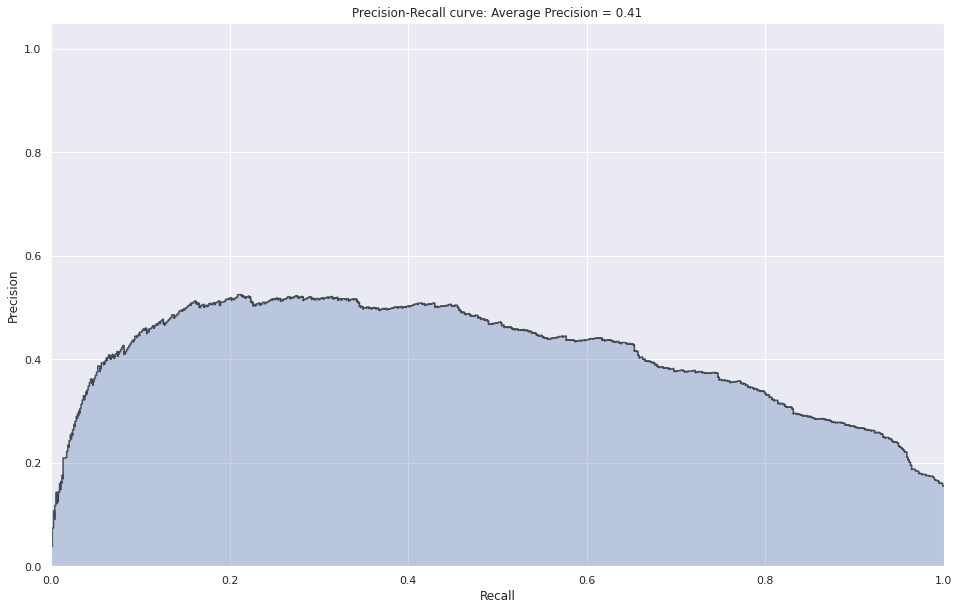

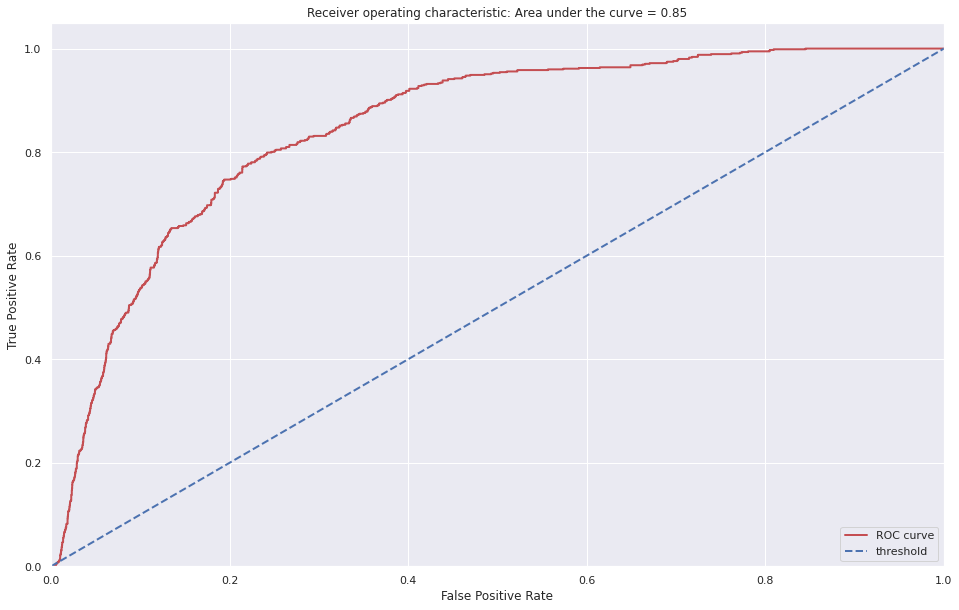

In [19]:
plot_precision(y, y_sparse_pca_pred)
plot_auc(y, y_sparse_pca_pred)

## Apply `GaussianRandomProjection`

In [20]:
from sklearn.random_projection import GaussianRandomProjection

grp = GaussianRandomProjection(n_components = 52, eps = 0.5, random_state = 2018)

X_grp: ndarray = \
    grp.fit_transform(X_clean)

X_grp_inverse: ndarray = \
    X_grp @ (grp.components_) + X_clean.mean(axis = 0)

y_grp_pred: ndarray = \
    predict(X_clean, X_grp_inverse)

f'precision: {average_precision_score(y, y_grp_pred)}'

'precision: 0.17389001191408693'

In [21]:
from sklearn.random_projection import GaussianRandomProjection

grp = GaussianRandomProjection(n_components = 52, eps = 0.5, random_state = 2018)

X_grp: ndarray = \
    grp.fit_transform(X_raw)

X_grp_inverse: ndarray = \
    X_grp @ (grp.components_) + X_raw.mean(axis = 0)

y_grp_pred: ndarray = \
    predict(X_raw, X_grp_inverse)

f'precision: {average_precision_score(y, y_grp_pred)}'

'precision: 0.3571473223337868'

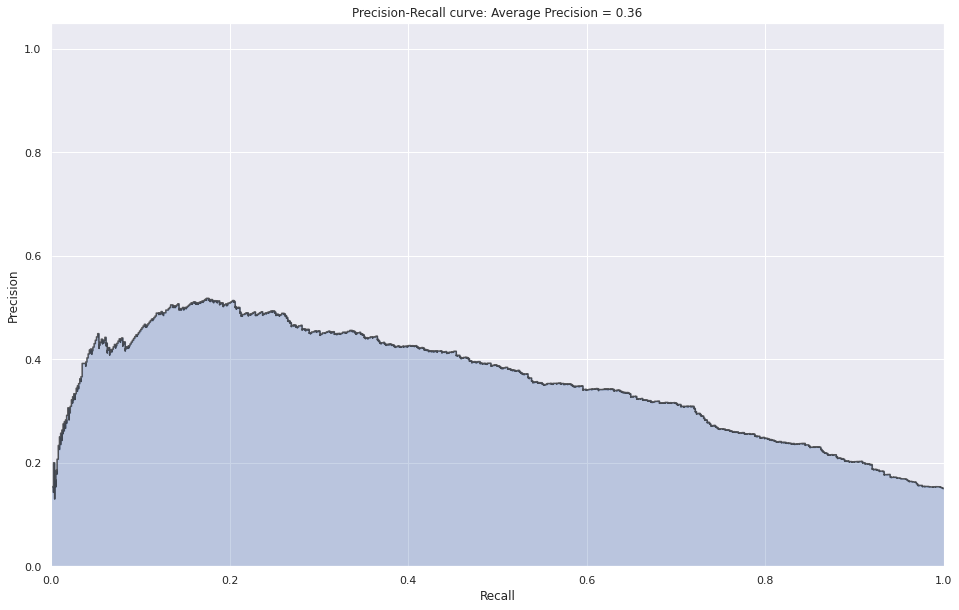

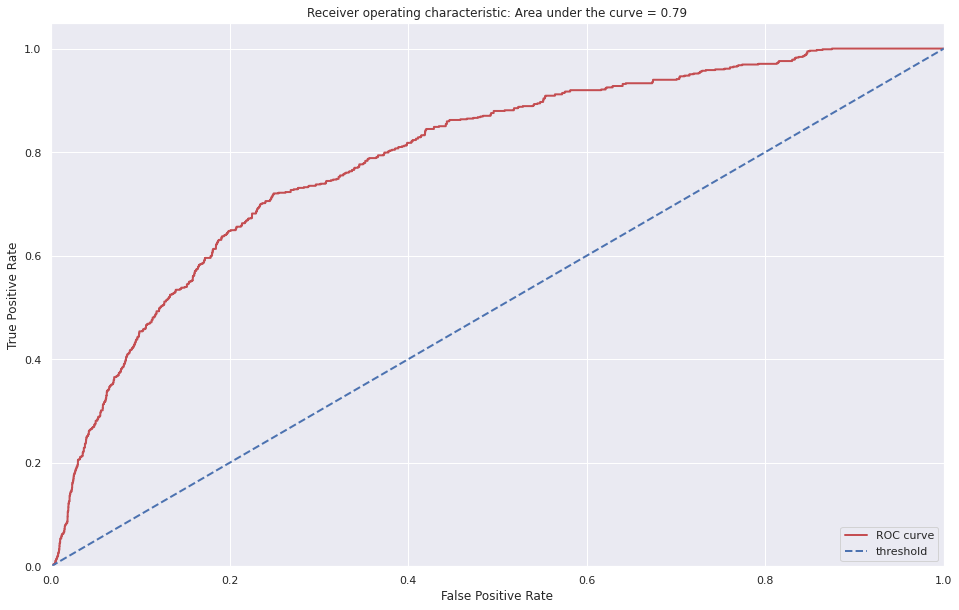

In [22]:
plot_precision(y, y_grp_pred)
plot_auc(y, y_grp_pred)

## Apply `SparseRandomProjection`

In [23]:
from sklearn.random_projection import SparseRandomProjection

srp = SparseRandomProjection(n_components = 52, 
                             density = 'auto',
                             eps = 0.5,
                             dense_output = False,
                             random_state = 2018)

X_srp: ndarray = \
    srp.fit_transform(X_clean)

X_srp_inverse: ndarray = \
    X_srp @ (srp.components_) + X_clean.mean(axis = 0)

y_srp_pred: ndarray = \
    predict(X_clean, X_srp_inverse)

f'precision: {average_precision_score(y, y_srp_pred)}'

'precision: 0.17665507200022512'

In [24]:
from sklearn.random_projection import SparseRandomProjection

srp = SparseRandomProjection(n_components = 52, 
                             density = 'auto',
                             eps = 0.5,
                             dense_output = False,
                             random_state = 2018)

X_srp: ndarray = \
    srp.fit_transform(X_raw)

X_srp_inverse: ndarray = \
    X_srp @ (srp.components_) + X_raw.mean(axis = 0)

y_srp_pred: ndarray = \
    predict(X_raw, X_srp_inverse)

f'precision: {average_precision_score(y, y_srp_pred)}'

'precision: 0.3751088054411722'

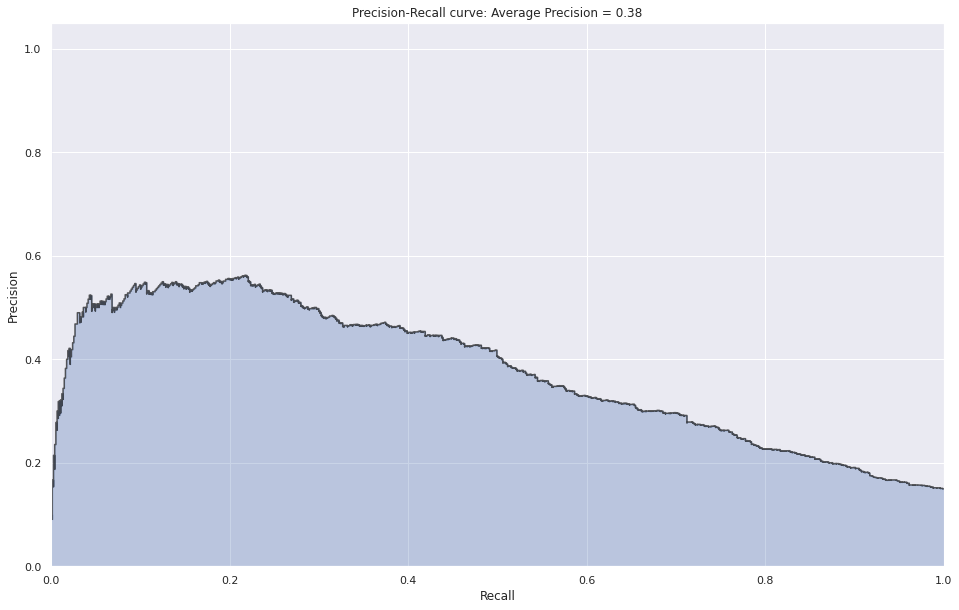

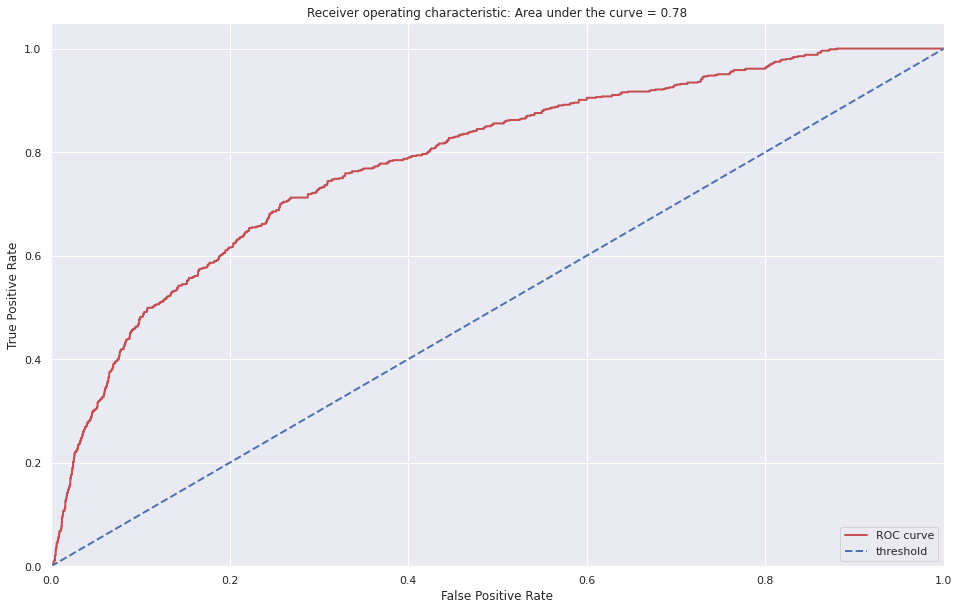

In [25]:
plot_precision(y, y_srp_pred)
plot_auc(y, y_srp_pred)

## Apply `MiniBatchDictionaryLearning`

In [26]:
from sklearn.decomposition import MiniBatchDictionaryLearning

dictionary_learning = \
    MiniBatchDictionaryLearning(n_components = 23,
                                alpha = 1,
                                batch_size = 200, 
                                n_iter = 25,
                                random_state = 2018)

X_dictionary_learning: ndarray = \
    dictionary_learning.fit_transform(X_clean)

X_dictionary_learning_inverse: ndarray = \
    X_dictionary_learning @ (dictionary_learning.components_) + X_clean.mean(axis = 0)

y_dictionary_learning_pred: ndarray = \
    predict(X_clean, X_dictionary_learning_inverse)

f'precision: {average_precision_score(y, y_dictionary_learning_pred)}'

'precision: 0.24270620679651786'

In [27]:
from sklearn.decomposition import MiniBatchDictionaryLearning

dictionary_learning = \
    MiniBatchDictionaryLearning(n_components = 23,
                                alpha = 1,
                                batch_size = 200, 
                                n_iter = 25,
                                random_state = 2018)

X_dictionary_learning: ndarray = \
    dictionary_learning.fit_transform(X_raw)

X_dictionary_learning_inverse: ndarray = \
    X_dictionary_learning @ (dictionary_learning.components_) + X_raw.mean(axis = 0)

y_dictionary_learning_pred: ndarray = \
    predict(X_raw, X_dictionary_learning_inverse)

f'precision: {average_precision_score(y, y_dictionary_learning_pred)}'

'precision: 0.3934155808688068'

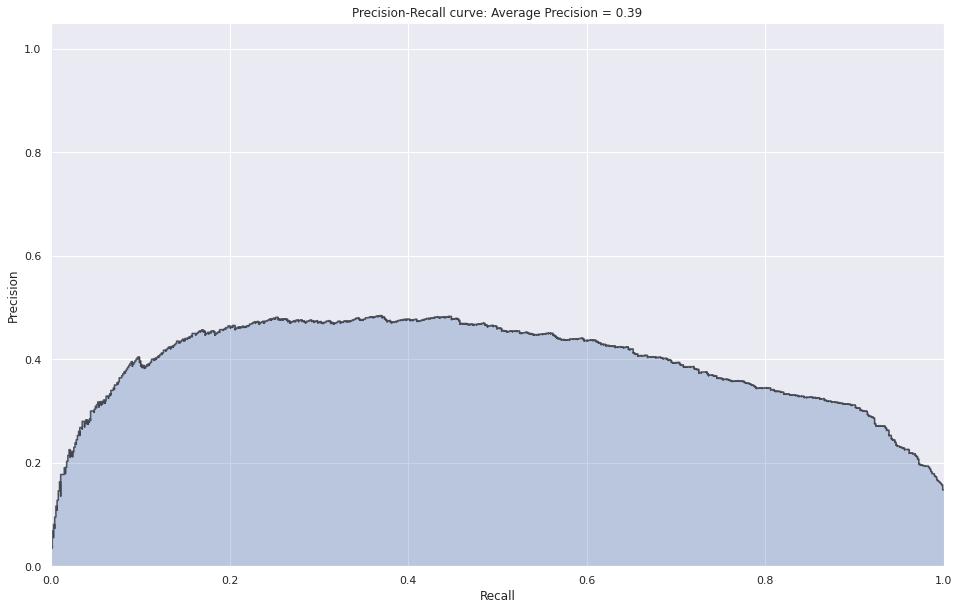

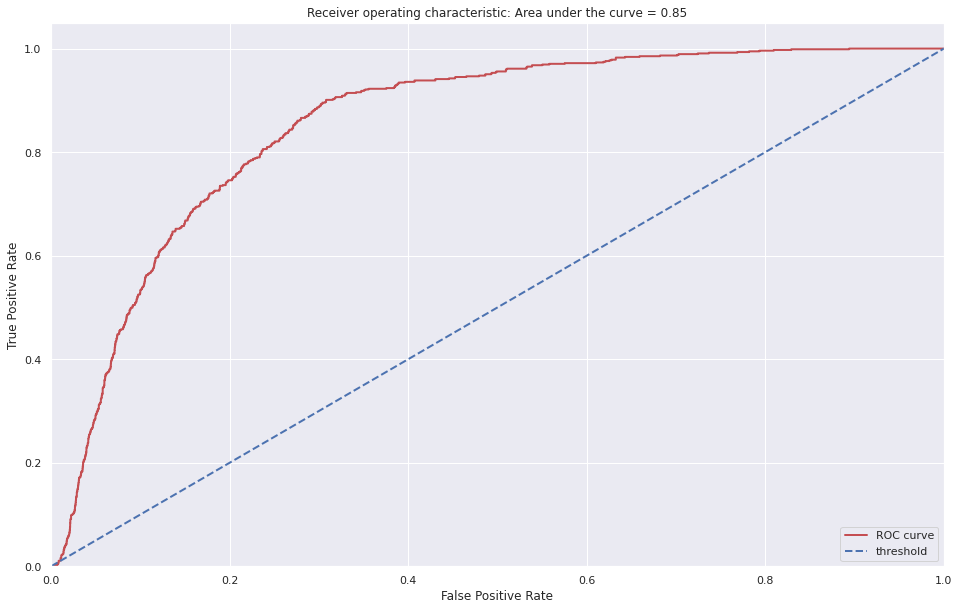

In [28]:
plot_precision(y, y_dictionary_learning_pred)
plot_auc(y, y_dictionary_learning_pred)

## Apply `FastICA`

In [29]:
from sklearn.decomposition import FastICA

fast_ICA = FastICA(n_components = 23, algorithm = 'parallel', whiten = True, max_iter = 100, random_state = 2018)

X_fast_ICA: ndarray = \
    fast_ICA.fit_transform(X_clean)

X_fast_ICA_inverse: ndarray = \
    fast_ICA.inverse_transform(X_fast_ICA)

y_fast_ICA_pred: ndarray = \
    predict(X_clean, X_fast_ICA_inverse)

f'precision: {average_precision_score(y, y_fast_ICA_pred)}'

'precision: 0.24510633551588493'

In [30]:
from sklearn.decomposition import FastICA

fast_ICA = FastICA(n_components = 23, algorithm = 'parallel', whiten = True, max_iter = 100, random_state = 2018)

X_fast_ICA: ndarray = \
    fast_ICA.fit_transform(X_raw)

X_fast_ICA_inverse: ndarray = \
    fast_ICA.inverse_transform(X_fast_ICA)

y_fast_ICA_pred: ndarray = \
    predict(X_raw, X_fast_ICA_inverse)

f'precision: {average_precision_score(y, y_fast_ICA_pred)}'

'precision: 0.39548922322804464'

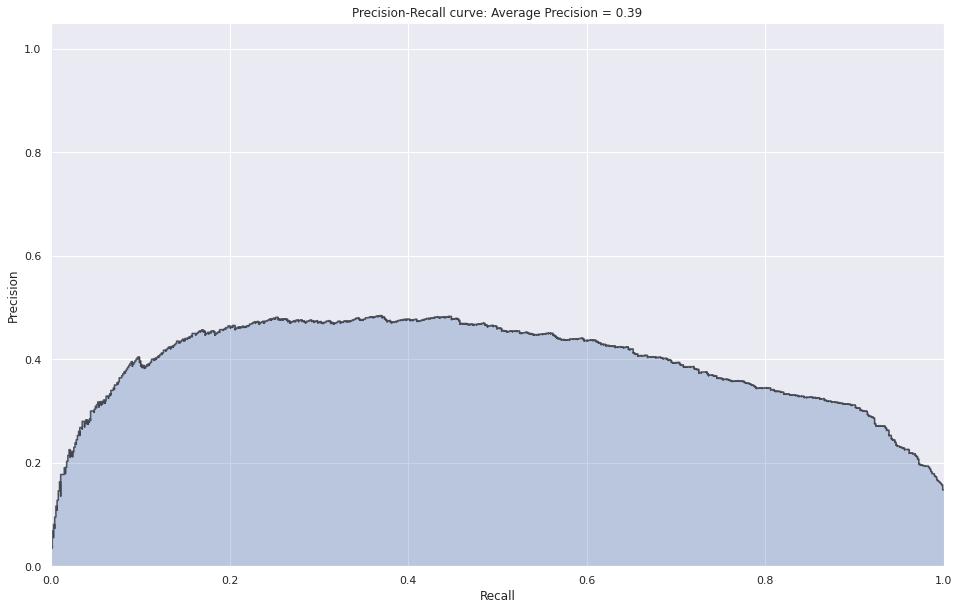

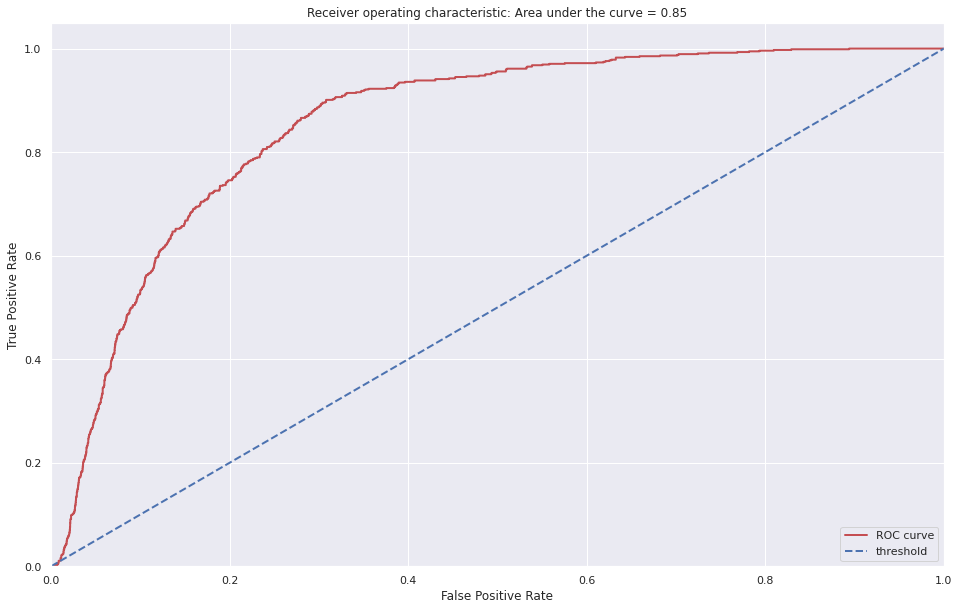

In [31]:
plot_precision(y, y_dictionary_learning_pred)
plot_auc(y, y_dictionary_learning_pred)